# Going Deeper 03 AI Lyrics Generator
###### 온라인 코어 2기 박수경  

이번 과제에서는 가사 데이터셋을 학습해 새로운 가사를 작성해 주는 인공지능을 구성해 보기로 한다. 규칙이 먼저 생기고 그에 맞는 문법에 따르는 기계어와는 다르게 자연적으로 존재하는 사람의 언어를 자연어라고 한다.  자연어는 규칙에 따라 생겨나는 것이 아니며, 따라서 통계적으로 접근하는 것이 가장 좋은 방법으로 알려져 있다.  

이번 과제에 사용하는 라이브러리들을 먼저 import 한다.

In [1]:
import glob  #glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import tensorflow as tf
import numpy as np
import os
import re #정규표현식
from sklearn.model_selection import train_test_split # 데이터셋 분리
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


## Step 1. 데이터 준비 및 읽어오기

glob 모듈을 사용해서 파일을 읽어온다. glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장한다.

In [2]:

txt_file_path = 'data/lyrics/*'

txt_list = glob.glob(txt_file_path)
raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담는다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:10])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]', 'You ever want something ', "that you know you shouldn't have ", "The more you know you shouldn't have it, ", 'The more you want it ', 'And then one day you get it, ', "It's so good too ", "But it's just like my girl "]


## Step 2. 데이터 정제

가사 데이터를 정제하는 함수 preprocess_sentence()를 정의하고 각 문장에 대해 적용한다.

지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거한다. 일반적으로 가사의 한 문장은 그렇게 길지 않기 때문에 적당한 길이의 문장을 학습하게 하는 것이다. 과제에서 제시한 max 토큰의 개수는 15개로, maxlen =15 로 설정한다.

정규표현식에서 https://stackoverflow.com/questions/13566052/using-r-with-variables-in-re-sub

한 문장에서 띄어쓰기를 기준으로 잘라 토큰화를 한다고 했을 때, 다음과 같은 처리를 할 필요가 있다.  
> 1. 모든 글자들을 소문자로 바꾸고, 양쪽 공백을 지우기
> 2. 특수문자 양쪽에 공백을 넣기
> 3. 여러개의 공백은 하나의 공백으로 바꾸기
> 4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾸기
> 5. 양쪽 공백 지우기
> 6. 문장 시작에는 <start>, 끝에는 <end>를 넣어 표시하기

In [3]:
# sentence에서 원하는 것만 남기기

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1 다 소문자로 만들기,strip :공백 지우기,
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 특수문자의 양쪽에 공백을 넣기 (\1 : 첫번째로 매치된 것에 대해) 
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러개의 공백은 하나의 공백으로 바꾼다.
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾼다 (^: 여)
    sentence = sentence.strip() # 공백을 지운다.
    sentence = '<start> ' + sentence + ' <end>' # 시작과 끝에 start,end 붙인다
    return sentence

In [4]:
# raw_corpus 안에 어떤 결과가 담겼는지 확인한다.

print(raw_corpus[:9])

['', '', '[Spoken Intro:]', 'You ever want something ', "that you know you shouldn't have ", "The more you know you shouldn't have it, ", 'The more you want it ', 'And then one day you get it, ', "It's so good too "]


 raw_corpus 에서 실제로 학습에 쓰일 문장들(elements)만 선택해서 corpus 리스트에 담는다. 이 때 가사가 아닌 line들은 corpus에 담지 않기 위해 여러 조건문을 사용하여 corpus에 append 한다. 

 일단 앞서 확인한 [Spoken Intro:] 같은 경우에도 가사가 아니다. 대체로 chorus: , verse: 같이 곡의 구성상의 역할을 알려주는 line은 가사가 아니므로 제외하고 싶었다.
 이런 line들의 경우 끝이 :], :), :, ], ) 등으로 끝나는데 )로 끝나는 경우는 가사에 속할 수도 있으므로 :], :), :, ] 로 끝나는 것을 제외하기로 결정했다. 

In [5]:

corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    #제외할 문장의 특성 -> continue: 건너뛰기

    if len(sentence) == 0: 
        continue
    if sentence[-1] == ":": 
        continue
    if len(sentence) == 0: 
        continue
    if sentence[-1] == "]": 
        continue

    if len(sentence) == 1: 
        continue

    if sentence[-2:] == ":]": 
        continue
    if sentence[-2] == ":)": 
        continue
    
    
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 몇 개 확인한다.
corpus[:10]

['<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>',
 '<start> but right now i just feel cold , so cold <end>']

### 토큰화 (Tokenize)  
텐서플로우의 Tokenizer와 pad_sequences를 사용한다.
가사에 사용되는 단어장의 크기는 20000으로 설정했다. 시간은 더 걸릴 수 있지만 풍부한 단어가 확보되어 더 괜찮은 작사봇이 될 수 있겠다고 생각했기 때문이다. 단어장에 포함되지 못한 단어는 unknown으로 처리한다.  
pad_sequence 의 패딩 처리방법은 default 가 'pre' 이다. 따라서 뒤에 패딩을 추가하기 위해 'post'를 옵션으로 준다.


In [6]:

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=18000, 
        filters=' ',
        oov_token="<unk>"
    )
    
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, \
        padding='post',maxlen=15)  # 길이가 짧은 문장은 뒤에서부터 패딩(post), 토큰의 최대길이: 15  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2    7  156 ...    0    0    0]
 [   2   17    7 ...    0    0    0]
 [   2    6   98 ...    0    0    0]
 ...
 [   2  310    1 ...    0    0    0]
 [   5   34   45 ... 1163  142    3]
 [   5   34   45 ... 1163  142    3]] <keras_preprocessing.text.Tokenizer object at 0x7f490ad9b100>


tokenizer.index_word 로 토큰들의 인덱스와 해당 단어를 딕셔너리로 확인할 수 있다. 스무개 정도만 확인해 보도록 한다.

In [7]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형대로 반환 (Ex. {index: '~~', index: '~~', ...})
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 20: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to
11 : it
12 : me
13 : my
14 : in
15 : t
16 : s
17 : that
18 : on
19 : of
20 : your


정제된 문장을 토큰화까지 마치고 데이터를 텐서로 만들었다. 이제는 사이킷런의 train_test_split()으로 데이터를 분리하려고 한다. train_test_split()을 사용하려면 X, y(target)으로 데이터가 분리되어 있어야 하므로 tensor를 src_input과 tgt_input으로 분리한다.

In [8]:

src_input = tensor[:, :-1]  
tgt_input = tensor[:, 1:]  

In [9]:
print(src_input[0])
print(tgt_input[0])

[  2   7 156  62 201   3   0   0   0   0   0   0   0   0]
[  7 156  62 201   3   0   0   0   0   0   0   0   0   0]


## Step 3. 평가 데이터셋 분리

In [10]:


enc_train, enc_val, dec_train, dec_val = \
    train_test_split(src_input, tgt_input, \
        test_size=0.2, random_state=1004, shuffle=True)


In [11]:
#데이터가 잘 분리되었는지 확인
print(enc_train.shape)
print(enc_val.shape) 
print(dec_train.shape) 
print(dec_val.shape)

(139572, 14)
(34894, 14)
(139572, 14)
(34894, 14)


buffer_size, batch_size, epoch, iteration을 다시 공부하는 계기가 되었다.
(https://losskatsu.github.io/machine-learning/epoch-batch/)

- Batch Size : 1회 역전파에서 gradient를 모을 데이터의 개수  
- Buffer Size : 전체 데이터의 개수  

- VOCAB_SIZE : 단어들의 개수와 padding '0'까지 합쳐서 +1

In [12]:
BUFFER_SIZE = len(src_input) # 전체 문장의 개수
print(BUFFER_SIZE)
BATCH_SIZE = 512 
print(BATCH_SIZE)
steps_per_epoch = len(src_input) // BATCH_SIZE 
print(steps_per_epoch)
VOCAB_SIZE = tokenizer.num_words + 1   # padding '0' 까지 합쳐서 +1
print(VOCAB_SIZE)

174466
512
340
18001


In [13]:
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
print(dataset)

dataset = dataset.shuffle(BUFFER_SIZE)
print(dataset)

dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<TensorSliceDataset shapes: ((14,), (14,)), types: (tf.int32, tf.int32)>
<ShuffleDataset shapes: ((14,), (14,)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((512, 14), (512, 14)), types: (tf.int32, tf.int32)>


## Step 4. 인공지능 만들기

모델을 구성한다. 자연어처리에 적절한 LSTM 을 사용하도록 한다. LSTM은 RNN에서 발전된 그것의 한 종류로 'cell state', 'gate'의 개념을 다시 정리할 수 있었다. 

hidden_size1, hidden_size2 을 다르게 설정해도 된다. 하지만 (1024, 1024)일 때 가장 성능이 좋았다.  
시도해본 값 : (1024, 512), (2048, 1024), (512, 512)


In [14]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size, hidden_size_2): # hidden_size
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True) 
        self.dp1 = tf.keras.layers.Dropout(0.25)
        self.dp2 = tf.keras.layers.Dropout(0.25)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size_2, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.dp1(out) #드랍아웃 층을 추가해보기도, 빼보기도 했다.
        out = self.rnn_2(out)
        out = self.dp2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 1024
hidden_size = 1024

hidden_size_2 = 1024

model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size, hidden_size_2) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.

In [15]:
# 데이터셋에서 데이터 한 배치만 불러와서 모델에 넣어 본다.

for src_sample, tgt_sample in dataset.take(1): break

model(src_sample)

<tf.Tensor: shape=(512, 14, 18001), dtype=float32, numpy=
array([[[-2.66729534e-04, -1.36932911e-04, -4.14854694e-05, ...,
          2.50847224e-04,  2.34649015e-05, -3.77349643e-04],
        [-3.29417060e-04, -4.43459459e-04, -2.93988560e-04, ...,
          1.48530657e-04, -1.57207905e-04, -4.24889266e-04],
        [-2.40203444e-04, -6.64155523e-04, -5.10229846e-04, ...,
         -2.65822222e-04, -5.02532639e-04, -1.30445609e-04],
        ...,
        [-7.63678749e-04, -1.79349550e-03, -1.35645701e-03, ...,
          1.46776414e-03,  1.10552937e-04, -4.99990478e-04],
        [-7.76390429e-04, -1.37492560e-03, -1.23248238e-03, ...,
          1.43815612e-03,  2.19180329e-05, -5.22951537e-04],
        [-8.68742063e-04, -9.88657470e-04, -1.08741503e-03, ...,
          1.28382654e-03, -1.75155292e-04, -7.00070581e-04]],

       [[-2.66729534e-04, -1.36932911e-04, -4.14854694e-05, ...,
          2.50847224e-04,  2.34649015e-05, -3.77349643e-04],
        [-5.74644306e-04, -2.51092744e-04,  2

In [16]:
# 모델의 구조 확인.
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  18433024  
_________________________________________________________________
lstm (LSTM)                  multiple                  8392704   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  18451025  
Total params: 53,669,457
Trainable params: 53,669,457
Non-trainable params: 0
________________________________________

옵티마이저로 adam 을 사용한다. 
loss 로는 SparseCategoricalCrossentropy. 설정 파라미터 from_logits, reduction 을 잘 몰라서 찾아보았다.

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, \
                                     beta_1=0.8, beta_2= 0.9,epsilon=1e-07, amsgrad=True)
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 학습 데이터의 label이 정수일 경우 사용하는 손실함수
    from_logits=True, # 기본값 False. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값 SUM이다. 각자 나오는 값의 반환을 원할 때 None을 사용한다.
)
# 컴파일
model.compile(loss=loss, optimizer=optimizer) 

learning_rate를 기본값에서 0.005로 바꾸었을 때 전체적으로 가장 성능이 잘 나왔다.  
(시도해본 값 : 0.001, 0.005, 0.003, 0.002,  0.01)

In [18]:
history = model.fit(enc_train, dec_train, epochs=3, batch_size=BATCH_SIZE, validation_data = (enc_val, dec_val))

Epoch 1/3
273/273 [==============================] - 140s 503ms/step - loss: 3.7975 - val_loss: 3.3473
Epoch 2/3
273/273 [==============================] - 137s 502ms/step - loss: 3.2657 - val_loss: 3.1806
Epoch 3/3
273/273 [==============================] - 137s 502ms/step - loss: 3.1184 - val_loss: 3.0800


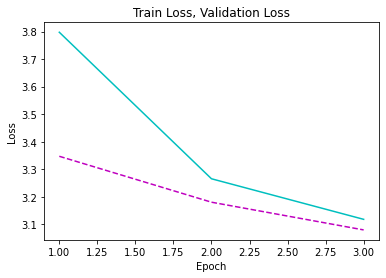

In [19]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
epoch = range(1, len(loss) + 1)

plt.plot(epoch, loss, 'c-', label='train_loss')
plt.plot(epoch, val_loss, 'm--', label='val_loss')
plt.title('Train Loss, Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

loss를 그래프로 나타내었다. val_loss가 증가하기 시작하는 지점이 과대적합이 시작되는 지점이다. 

## Step 5. 가사 생성

In [20]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15): 
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
       
        predict = model(test_tensor) 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated 

In [23]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=15)

'<start> i love you , i m a little one <end> '

## Discussion

- 모델을 구성하고 model.build()나 model.fit()을 한번이라도 하지 않으면 model.summary()를 볼 수 없기 때문에 model(src_sample)로 한 번 넣어 본 것이다.  

- loss SparseCategoricalCrossentropy, from_logits, reduction 에 대해 한번 더 찾아보고 정리할 수 있었다. 


- keras subclassing 방법으로 모델을 만들 때.  

 ![](https://d3s0tskafalll9.cloudfront.net/media/images/E-12-4.max-800x600.png) 
 
 제시된 코드는  
 ```python  
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    ```
    
   이다.  그런데 모델 안의 rnn1 레이어와 rnn2 레이어는 완전히 같은 층이어서 다르게 이름을 줄 필요가 있는지 의문이 들었다. 만약 층이 동일하다면 \__ init\__ 에서 LSTM 레이어를 하나만 설정하고 call 안에서 같은 층을 두 번 통과하게 하면 될 일이 아닌가하고 생각을 했다.  
   그러나 학습된 데이터가 층을 통과하면 그 층이 결국 배운 건 '파라미터',즉 웨이트이다. 만일 다시 그 층을 통과하게 되면 기껏 처음 통과하며 배운 웨이트가 변하게 되어서 의미가 없어진다. 층을 통과하며 학습된 웨이트가 다르기 때문에 두 층은 다르게 설정해야 한다는 사실을 알았다. (freeze의 원리와도 동일한 이유)  
   딥러닝 모델에 대해 조금 더 곰곰히 생각해 보는 기회가 되었다.
 
 

- 모델의 하이퍼파라미터 뿐만이 아니라 words 의 개수를 조절했을 때도 확연한 차이가 있었다. 단어장의 크기를 24000, 20000, 18000개등 시도를 해 봤는데 18000개일 때 가장 성능이 좋았다. 나는 어휘가 풍부하면 더 성능이 좋을 거라고만 생각을 했는데 그게 아니었다. 물론 단어장의 크기가 크면 그에 맞는 모델의 하이퍼파라미터가 딱 있을 거지만, 내가 설정하기엔 아직 fine-tuning하는 것이 어려웠다.  

- 드랍아웃 층의추가.  
    TextGenerator(tf.keras.Model)의 구조를 짜면서 층 사이에 드랍아웃 층을 추가해 보기도 했고 위치를 옮겨보기도 했다. 

- 결과가 loss 2.2 밑으로 내려가지 못했다.

## References


- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer (토크나이즈)  
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences (문장에 패딩주기)

- https://codetorial.net/tensorflow/natural_language_processing_in_tensorflow_01.html (tokenizer의 여러가지 사용법에 대해 찾아보고 토큰으로 인코딩하는 방법에 조금 더 익숙해질 수 있었다.)

- https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear  
- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam (아담의 베타값 설정)

- https://hyunw.kim/blog/2017/11/01/Optimization.html (옵티마이저)